In [1]:
%matplotlib inline 
import mysql.connector
import pandas as pd
from TrainTest import TrainTest
from textblob import TextBlob
import numpy as np
import csv
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
matplotlib.style.use('ggplot')
import random
pd.options.mode.chained_assignment = None


In [2]:
#connect to mysql
cnx = mysql.connector.connect(host='152.19.68.141', user='ctolson', password='ilaYOU5!', database='sephora_cosmetics')
cursor = cnx.cursor()

#query reviews by product1
query = ("SELECT R.product_id, review_id, review, reviewer, type "
         "FROM Reviews as R "
         "JOIN Product as P "
         "ON P.product_id = R.product_id ")
cursor.execute(query)


#close mysql server
cnx.close()

In [3]:
#clean reviews data
product_id = []
review_id = []
reviews = []
reviewers = []
types = []
for (x, y, z, w, v) in cursor:
    product_id.append(int(x))
    review_id.append(int(y))
    reviews.append(z)
    reviewers.append(w)
    types.append(v)

#convert to data frame
data = list(zip(product_id, review_id, reviews, reviewers, types))
review_data = pd.DataFrame(data=data, index=range(0,len(reviews)), columns=['product_id', 'review_id', 'reviews', 'reviewers', 'types'])


In [4]:
#get train/test set review ids
training = TrainTest()
ttset = training.getSet()
train= ttset['train']
test= ttset['test']

#create train/test set
review_train = review_data.loc[review_data['review_id'].isin(train)]
review_test = review_data.loc[review_data['review_id'].isin(test)]

#convert series to lists
reviews = review_test['reviews'].tolist()


In [5]:
#get sentiment polarity for reviews
sentiment = [TextBlob(x).sentiment.polarity for x in reviews]

#find binary sentiment
sentiment = [int(x>0.25) for x in sentiment]
sentiment = pd.Series(sentiment, index=review_test.index)
review_test['sentiment'] = sentiment


In [6]:
#group by reviewers and product__id
reviewers_testsent = review_test.groupby('reviewers')['sentiment'].apply(list).tolist()
product_testsent = review_test.groupby('reviewers')['product_id'].apply(list).tolist()
types_testsent = review_test.groupby('reviewers')['types'].apply(list).tolist()
product_id = review_train.groupby('product_id')['product_id'].first().tolist()

#convert to list
reviewers_testsent = [list(x) for x in reviewers_testsent]
product_testsent = [list(x) for x in product_testsent]
product_id = [x for x in product_id]

#read in distance
review_d = pd.read_csv('../../Data/dist_reviews_lsi.csv', header=0)
review_dist = review_d.drop('product_id', 1)
review_dist= review_dist.as_matrix()
reviewer_d = pd.read_csv('../../Data/dist_reviews_item.csv', header=0)
reviewer_dist = reviewer_d.drop('product_id', 1)
reviewer_dist = reviewer_dist.as_matrix()

In [17]:
#write distance to file
fl = open('../../Data/dist_reviews.csv', 'w')
writer = csv.writer(fl)
writer.writerow(['product_id']+product_id)

#initialize variables
a=0.5
b=1
d = [0 for x in review_dist]
dist = collections.defaultdict(lambda: collections.defaultdict(int))

#combine distances 
for i in range(0,len(d)):
    for j in range(0,len(d)):
        #get distances
        d[j] = (a*float(review_dist[i,j]) + b*float(reviewer_dist[i,j]))/1.5  
        dist[str(product_id[i])][str(product_id[j])] = d[j]
     
    #save combined distances
    writer.writerow([product_id[i]]+d)

#close file
fl.close()  


In [18]:
#initialize options
liked1 = []
liked2 = []
liked3 = []
liked4 = []

#compare sentiment difference vs. predicted distance
for i in range(0,len(reviewers_testsent)):
    for j in range(0,len(reviewers_testsent[i])):
        for k in range(0,len(reviewers_testsent[i])):
            #compare actual and predicted
            predicted = dist[str(product_testsent[i][j])][str(product_testsent[i][k])]
            actual = int(reviewers_testsent[i][j]>0) + int(reviewers_testsent[i][k]>0)
            actual_type = int(types_testsent[i][j] == types_testsent[i][k])
                
            #liked v. disagree v. dislike
            if actual>1 and actual_type==1:
                liked1.append(predicted)
            elif actual_type==1: 
                liked2.append(predicted)
                    
            #same v. different
            if actual_type==1:
                liked3.append(predicted)
            else:
                liked4.append(predicted)
   

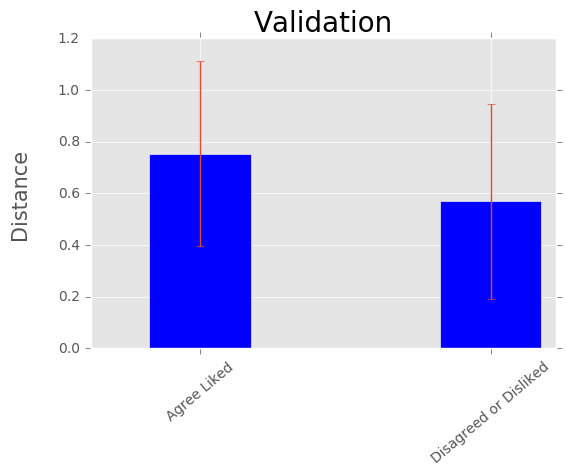

[0.75384473106559724, 0.56967482926711366]


In [19]:
#means and standard deviation
avg = [np.nanmean(liked1),np.nanmean(liked2)]
sd = [np.nanstd(liked1),np.nanstd(liked2)]

#plot figure
fig = plt.figure()
ax = fig.add_subplot(111)

#figure specifics
ind = [1,2]              
width = 0.35  

#plot barplot
ax.bar(ind, avg, width, color='blue',yerr=sd)

#plot specifics
plt.ylabel('Distance', fontsize=15, labelpad=20)
plt.title('Validation', fontsize=20)
ax.set_xticks([(width/2)+1,(width/2)+2])
ax.set_xticklabels(('Agree Liked', 'Disagreed or Disliked'),rotation=40)
plt.ylim([0,1.2])

#show plot
plt.show()

print(avg)



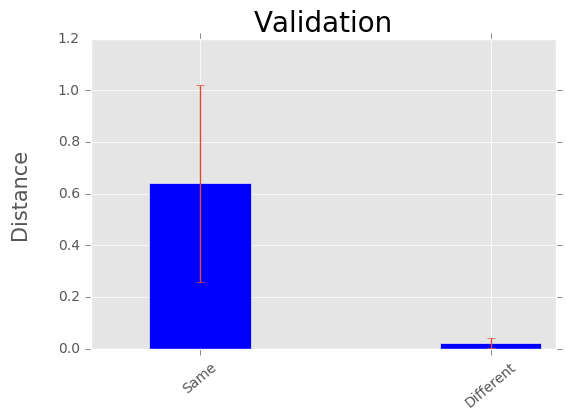

[0.63905289688178712, 0.021715393413090586]


In [20]:
#means and standard deviation
avg = [np.nanmean(liked3),np.nanmean(liked4)]
sd = [np.nanstd(liked3),np.nanstd(liked4)]

#plot figure
fig = plt.figure()
ax = fig.add_subplot(111)

#figure specifics
ind = [1,2]              
width = 0.35  

#plot barplot
ax.bar(ind, avg, width, color='blue',yerr=sd)

#plot specifics
plt.ylabel('Distance', fontsize=15, labelpad=20)
plt.title('Validation', fontsize=20)
ax.set_xticks([(width/2)+1,(width/2)+2])
ax.set_xticklabels(('Same','Different'),rotation=40)
plt.ylim([0,1.2])

#show plot
plt.show()

print(avg)